#Conversion in Conic form

We start from the log-barrier Risk Parity problem:

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&\frac{1}{2} x^T \Sigma x - c \sum_{i=1}^{n} b_i ln(x_i)\\
& \text{s.t.}
&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$



The covariance matrix $\Sigma$ is positive semidefinite by definition and therefore there exist a matrix $G$ such that

$$
\Sigma = G G^T
$$

In general the choice of $G$ is not unique and one possible choice of $G$ is the Cholesky factorization of $\Sigma$. For a given $G$ we have that

$$
x^T \Sigma x = x^T G G^T x \\= ||\text{ } G^Tx \text{ }||^2
$$

If we introduce the auxiliary variable $z$, we have

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&z  - c \sum_{i=1}^{n} b_i ln(x_i)\\\\
& \text{s.t.}
&& \frac{1}{2}z \geq ||\text{ } G^Tx \text{ }||^2\\
&&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$

The constraint 

$$
\frac{1}{2}z \geq ||\text{ } G^Tx \text{ }||^2
$$

can be written as

$$
(z,1,Gx) \in \mathcal{Q}^{n+2}_r
$$

We now introduce an auxiliary vector of $n$ variables $t$:

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&z- c \sum_{i=1}^{n}t_i\\
& \text{s.t.}
&& (z,1,Gx) \in \mathcal{Q}^{n+2}_r\\
&&& t_i \leq b_i ln(x_i) \hspace{1em} \forall i \\
&&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$



#Sequential Cuts Algorithm

Since we can't write the constraint

$$
t_i \leq b_i ln(x_i) \hspace{1em} \forall i 
$$

using MOSEK Fusion API (there is no way to express the logarithmic term), we use a linear approximation of the logarithm. In the following part, we show how the logarithm function can be approximated using $k$ tangent lines in $k$ random points.

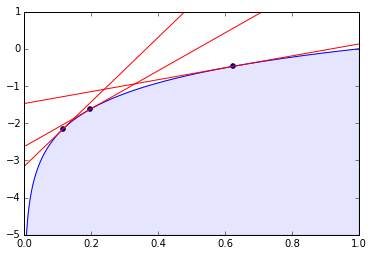

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

k=3

#plot the logarithmic function
x = np.arange(0.0001,1,0.0001)
log_x = np.log(x)
plt.axis([0, 1, -5, 1])
plt.plot(x,log_x)
plt.fill_between(x, log_x, -5, alpha=0.1)

#generate k random points
rand_x = np.random.sample(k)
rand_x.sort()
log_rand_x = np.log(rand_x)
plt.scatter(rand_x, log_rand_x)

#compute m and c of the tangent lines (y=m*x + c)
m_s = 1/rand_x
c_s = - 1 + log_rand_x

for i in range(k):
    plt.plot(x, m_s[i]*x + c_s[i], color='r')
           

The pseudo algorithm used is described below:


$\textbf{ Sequential Cuts algorithm }$

1. Solve the unconstrained problem to obtain initial guess for $x$ and $t$

2. Repeat

    2.1) Compute the tangent line ($m_i$ and $c_i$) for all $x_i$

    2.2) Add the constraints $t_i < m_i x_i + c_i$ for all $i \in \{1,..,n\}$ to the model
    
    2.3) Solve the constrained problem



The function that generates the cuts is the following:

In [19]:
def generateCuts(t, x, b, n, epsilon):
    #keep track of the largest constraint violation
    max_violation = 0
    
    for i in range(n):
        log_x = np.log(x[i])
        
        #if the constraint is violated
        if(t[i] > b[i]*log_x):
            if(t[i] - b[i]*log_x > max_violation):
                max_violation = t[i] - b[i]*log_x
    
    #if the maximum violation is larger than epsilon, we need to add a cut
    if(abs(max_violation)>epsilon):
        m = b/x 
        c = b*(- 1 + np.log(x))
        return m,c   
    else:
        #if not, return 0
        return np.zeros(n), np.zeros(n)

#MOSEK Fusion Implementation

First of all, we generate the random covariance matrix $Q$ and the random budget vector $b$

In [20]:
import numpy as np

n=10

#random covariance matrix
A = np.random.sample([n,n])
Q = np.dot(A,A.transpose())

#random budget vector
b = np.random.sample(n)
b = b/np.sum(b)

Now, the Cholesky factorization of the covariance matrix is performed. The result is saved in the variable $G$.

In [21]:
from scipy import linalg 
from mosek.fusion import *

chol = linalg.cholesky(Q)
G = DenseMatrix(chol)

We use the <a href="http://docs.mosek.com/7.1/pythonfusion/index.html">MOSEK Fusion API</a> to define a $\textbf{model}$.

In [22]:
with Model("Log-Barrier") as M:
    
    #define the variables
    x = M.variable("x", n, Domain.greaterThan(0.0))
    t = M.variable("t", n, Domain.lessThan(0.0))
    z = M.variable("z", 1, Domain.greaterThan(0.0))

    #add the conic constraint
    M.constraint(Expr.vstack(Expr.constTerm(1, 1.0),
                 z.asExpr(),
                 Expr.mul(G,x)),
                 Domain.inRotatedQCone())
    
    #set up the objective function and solve
    M.objective(ObjectiveSense.Minimize, Expr.sub(z, Expr.sum(t)))
    M.solve()
    
    convergence = False
    epsilon = 0.000000001
    k=0
    while (not convergence):  
        
        #generate m and c for all components of x
        [m, c] = generateCuts(t.level(), x.level(), b, n, epsilon)
        if not np.equal(m.all(),np.zeros(n).all()):
            m_coeff = np.diag(m)
            
            #add the constraints and solve again
            M.constraint(Expr.sub(t, Expr.mul(m_coeff,x)), Domain.lessThan(c))               
            M.solve()                
        else:
            convergence = True
            
    #normalize the solution       
    xx =  x.level()/np.sum(x.level())

Now we can print the Risk Parity solution found:

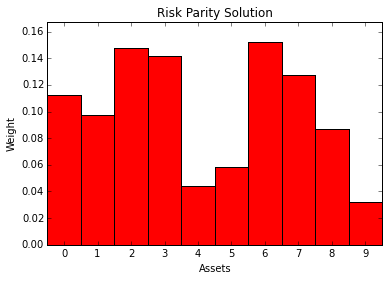

In [23]:
import barchart

barchart.plot_bar(xx, 'r', 'Risk Parity Solution', 'Assets', 'Weight')

To verify that this is really a Risk Parity solution, we now compute the marginal risk contributions for all assets:

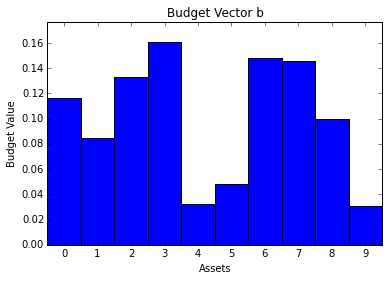

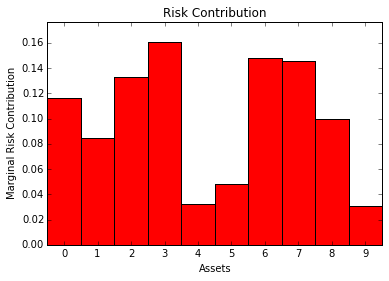

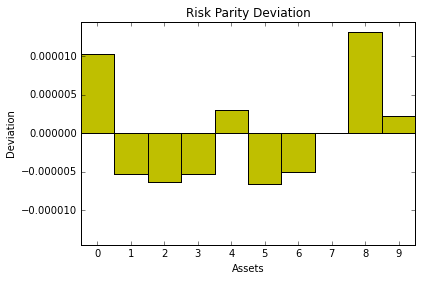

In [24]:
RC = np.zeros(n)
aux = Q.dot(xx)
volatility = xx.dot(aux)
for i in range(n):
    RC[i]=xx[i]*aux[i]/volatility
    
#print budget vector
barchart.plot_bar(b, 'b', 'Budget Vector b', 'Assets', 'Budget Value')

#print marginal risk contribution
barchart.plot_bar(RC, 'r', 'Risk Contribution', 'Assets', 'Marginal Risk Contribution')

#print the differences between the two above
barchart.plot_bar(RC-b, 'y', 'Risk Parity Deviation', 'Assets', 'Deviation')
    
 

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">MOSEK Fusion API Notebook</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.